In [1]:
from collections import defaultdict
from datetime import datetime
import os
import typing as tp

import cv2
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm.auto import tqdm
from scipy.ndimage.filters import gaussian_filter
import pickle


# Make the plots bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# Amogus analysis on Reddit's /r/Place

## Introduction

The /r/Place event on Reddit has briefly made it the talk of the entire internet, attracting people from all around the web and birthing all sorts of new fads and in-jokes.

One of these is the humble amogus:

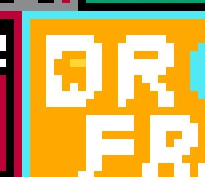

_An amogus hiding itself in the logo of the [Dropped Frames](https://droppedfram.es/) podcast._

A reference to the hit 2018 video game [Among Us](https://en.wikipedia.org/wiki/Among_Us), these are simple renditions of the game's crewmate characters on the canvas. Due to their simplicity and non-obtrusive nature, the players otherwise dissuaded from participating in a bigger community project had a freedom to spread them around the map by themselves, or with a small group of friends.

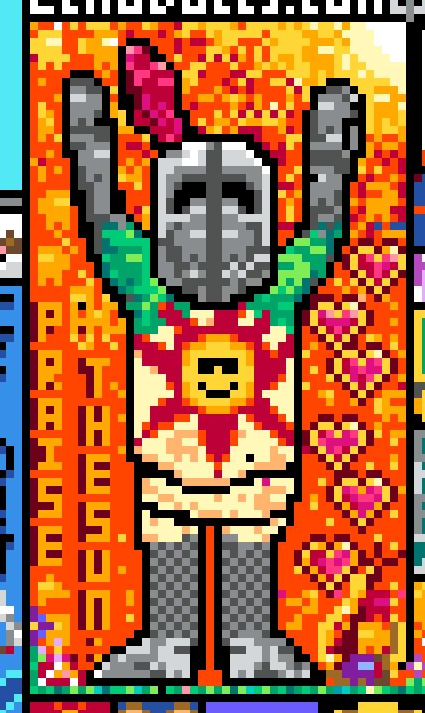

_Some are trickier to spot than others. How many can you count in this [Dark Souls](https://en.wikipedia.org/wiki/Dark_Souls) banner?_

In this notebook, we will study the phenomenon and make some conclusions on the nature of this fad.

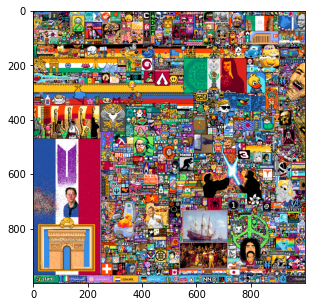

In [2]:
plt.imshow(
    cv2.cvtColor(
        cv2.imread("/kaggle/input/reddit-rplace-2022-history/images_quadro/2/2-1649111699.png"),
        cv2.COLOR_BGR2RGB
    )
)


### How would one detect an amogus in the picture?

The following approach will be used.

First, the image will be split into 32 channels, each corresponding to a possible colour.

In [3]:
def load_image(image_type: str, timestamp: int):
    
    if image_type == "single":
        image = cv2.imread(f"/kaggle/input/reddit-rplace-2022-history/images_single/0-{timestamp}.png")
        
    if image_type == "double":
        image_1 = cv2.imread(f"/kaggle/input/reddit-rplace-2022-history/images_double/0/0-{timestamp}.png")
        image_2 = cv2.imread(f"/kaggle/input/reddit-rplace-2022-history/images_double/1/1-{timestamp}.png")
        image = np.concatenate((image_1, image_2), axis=1)
        
    if image_type == "quadro":
        image_1 = cv2.imread(f"/kaggle/input/reddit-rplace-2022-history/images_quadro/0/0-{timestamp}.png")
        image_2 = cv2.imread(f"/kaggle/input/reddit-rplace-2022-history/images_quadro/1/1-{timestamp}.png")
        image_12 = np.concatenate((image_1, image_2), axis=1)
        image_3 = cv2.imread(f"/kaggle/input/reddit-rplace-2022-history/images_quadro/2/2-{timestamp}.png")
        image_4 = cv2.imread(f"/kaggle/input/reddit-rplace-2022-history/images_quadro/3/3-{timestamp}.png")
        image_34 = np.concatenate((image_3, image_4), axis=1)
        image = np.concatenate((image_12, image_34))
        
    return cv2.cvtColor(
        image,
        cv2.COLOR_BGR2RGB
    )

# questo si collega a autoload 

In [4]:
def autoload_image(timestamp: int):
    if f"0-{timestamp}.png" in os.listdir("/kaggle/input/reddit-rplace-2022-history/images_quadro/0"):
        return load_image("quadro", timestamp)
    if f"0-{timestamp}.png" in os.listdir("/kaggle/input/reddit-rplace-2022-history/images_double/0"):
        return load_image("double", timestamp)
    if f"0-{timestamp}.png" in os.listdir("/kaggle/input/reddit-rplace-2022-history/images_single"):
        return load_image("single", timestamp)
    raise ValueError(f"No image found for timestamp {timestamp}")
    
autoload_image(1649019007).shape
# ritorna l immagine dando il timestamp corrispondente

(2000, 2000, 3)

In [5]:
def list_images():
    return sorted([int(i.split("-")[1].split(".")[0]) for i in
        os.listdir("/kaggle/input/reddit-rplace-2022-history/images_quadro/0") +
        os.listdir("/kaggle/input/reddit-rplace-2022-history/images_double/0") +
        os.listdir("/kaggle/input/reddit-rplace-2022-history/images_single")
    ])

# elenca tutte le immagini presenti nelle directories

In [6]:
min(list_images()),max(list_images())
deltat = max(list_images()) - min(list_images())


In [7]:
# questo é l intervallo di tempo tra un immagine e l altra nel dataset
deltat = (72 * 3600) / len(list_images())
deltat

26.644736842105264

(33.03629446843512, 17.466922377582826)

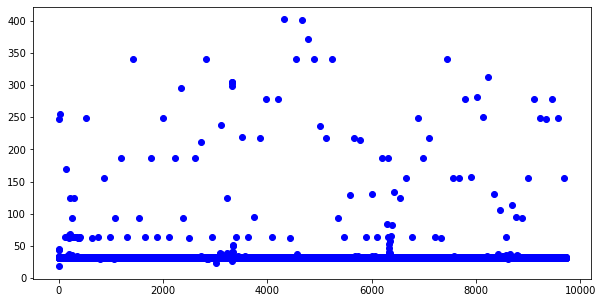

In [8]:
timestamp_valid = list_images()
#timestamp_valid = timestamp_valid[0:1000]

deltat = []
for i in range(1,len(timestamp_valid) - 1):
    deltat.append(timestamp_valid[i+1] - timestamp_valid[i])

plt.plot(deltat,'bo')
np.mean(deltat), np.std(deltat)

In [9]:
def collect_colours(image: np.array):
    colours = set()
    for x_beam in image:
        for pixel in x_beam:
            colours.add(tuple(pixel))
    return colours

COLOURS = list(collect_colours(load_image("quadro", 1649019007)))
assert len(COLOURS) == 32

In [10]:
def filter_image(image: np.array, colour: tp.Tuple[int, int, int]):
    colour_array = np.array(colour)[np.newaxis, np.newaxis, :]
    return 1 - np.clip(np.sum(np.abs(image - colour_array), axis=2), a_min=0, a_max=1)


def show_filtered(image: np.array, colour: tp.Tuple[int, int, int], ax=None, boundary = ((0, 2000), (0, 2000))):
    filtered = filter_image(image, colour)[..., np.newaxis]
    if ax:
        ax.imshow((image * filtered)[boundary[1][0]:boundary[1][1], boundary[0][0]:boundary[0][1]])
    else:
        plt.imshow((image * filtered)[boundary[1][0]:boundary[1][1], boundary[0][0]:boundary[0][1]])

def index_image(image: np.array):
    return np.stack([filter_image(image, i) for i in COLOURS], axis=2)

indexed_image = index_image(autoload_image(1649019007))
indexed_image.shape

(2000, 2000, 32)

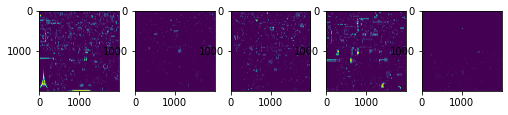

In [11]:
fig = plt.figure()
for i in range(0,5):
    ax = fig.add_subplot(1,6,i+1)
    plt.imshow(indexed_image[:,:,i],aspect='equal')
        

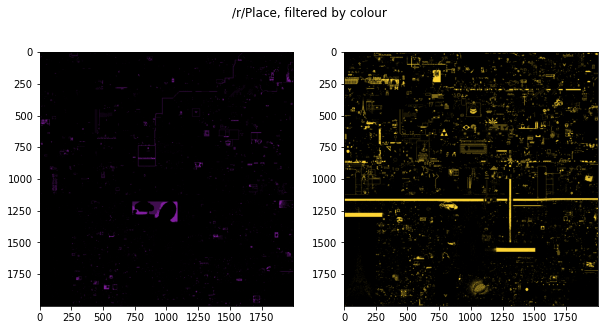

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("/r/Place, filtered by colour")

show_filtered(autoload_image(1649019007), (129, 30, 159), ax1)
show_filtered(autoload_image(1649019007), (255, 214, 53), ax2)

_Two of such channels._

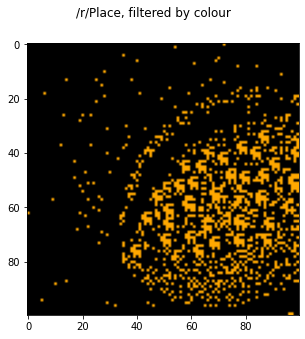

In [13]:
plt.suptitle("/r/Place, filtered by colour")
show_filtered(autoload_image(1649016793), (255, 168, 0), boundary=((990, 1090), (1800, 1900)))

_A notable amogus hotspot._

### Matching the amogus patterns with computer vision

In [14]:
INITIAL_TEMPLATES = [
"""
 ###
##  
####
 # #
""",
"""
 ###
##  
####
####
 # #
""",
"""
 ###
##  
####
 ###
 # #
"""
]

In [15]:
def parse_template(template):
    split_template = template.split("\n")[1:-1]
    template_arr = np.zeros((len(split_template), len(split_template[0])))
    for y, line in enumerate(split_template):
        for x, char in enumerate(line):
            template_arr[y][x] = 255 * (char == "#")
    return template_arr.astype("uint8")

parse_template(INITIAL_TEMPLATES[2])

array([[  0, 255, 255, 255],
       [255, 255,   0,   0],
       [255, 255, 255, 255],
       [  0, 255, 255, 255],
       [  0, 255,   0, 255]], dtype=uint8)

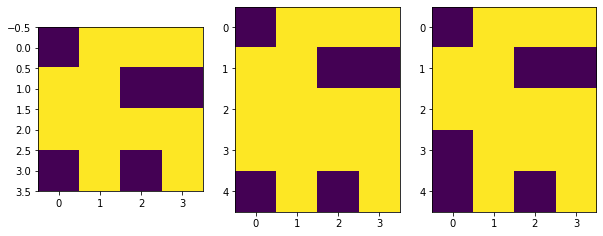

In [16]:
fig = plt.figure()

ax = fig.add_subplot(1, 3, 1)
plt.imshow(parse_template(INITIAL_TEMPLATES[0]))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(parse_template(INITIAL_TEMPLATES[1]))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(parse_template(INITIAL_TEMPLATES[2]))


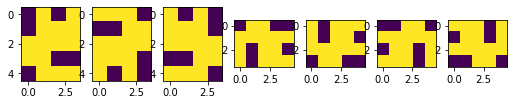

In [17]:
def augment_template(template: np.array):
    """Turn one template into many by rotating it"""
    return [
        template,
        template[::-1, :],
        template[:, ::-1],
        template[::-1, ::-1],
        template.T,
        template.T[::-1, :],
        template.T[:, ::-1],
        template.T[::-1, ::-1],
    ]


img_prova = augment_template(parse_template(INITIAL_TEMPLATES[2]))
fig = plt.figure()
for i in range(1,len(img_prova)):
    ax = fig.add_subplot(1,len(img_prova),i)
    plt.imshow(img_prova[i],aspect = 'equal')
        

In [18]:
def get_templates():
    return [aug_template for template in INITIAL_TEMPLATES for aug_template in augment_template(parse_template(template))]
# tutti i template possibili

In [19]:
def match_template(layer: np.array, template: np.array):
    match = 1 - cv2.matchTemplate((layer * 255).astype("uint8"),template,cv2.TM_SQDIFF).clip(0, 1)
    total_pad = [layer.shape[i] - match.shape[i] for i in range(2)]
    match = np.pad(match, [(total_pad[i] // 2, (total_pad[i] + 1) // 2) for i in range(2)])
    return match

def match_all_templates(layer: np.array):
    templates = get_templates()
    result = match_template(layer, templates[0])
    for template in templates[1:]:
        result = np.maximum(result, match_template(layer, template))
    return result
    
def detect_amogi(image: np.array):
    result = match_all_templates(image[..., 0])
    for layer_no in range(1, image.shape[-1]):
        result = np.maximum(result, match_all_templates(image[..., layer_no]))
    return result

In [20]:
timestamp = 1648924835
image = autoload_image(timestamp)
indexed_image = index_image(image)
amogi = detect_amogi(indexed_image)

fig = px.imshow(amogi.astype("float32"))
fig.show()

In [21]:
def interactive_amogus_map(timestamp: int):
    image = autoload_image(timestamp)
    indexed_image = index_image(image)
    amogi = detect_amogi(indexed_image)
    spotlight = gaussian_filter(amogi, sigma=5)
    spotlight /= 0.2 * np.max(spotlight)
    spotlight = spotlight.clip(0, 1)
    spotlight = 0.2 + 0.8 * spotlight
    datestring = datetime.fromtimestamp(timestamp).strftime("%A, %B %d %Y %I:%M:%S %p UTC")
    fig = px.imshow(image.astype("float32") * spotlight[..., np.newaxis] / 255, title=f"Interactive amogus map for {datestring}")
    fig.show()

#interactive_amogus_map(1648924835)

_An interactive Amogus finder map. Run this notebook with your own values to see other timestamps._

In [22]:
def count_amogi_at_timestamp(timestamp: int):
    image = autoload_image(timestamp)
    indexed_image = index_image(image)
    amogi = (detect_amogi(indexed_image) >= 0.5).astype("uint8") * 255
    
    n_amogi, _, _, _ = cv2.connectedComponentsWithStats(amogi)
    
    
    return n_amogi

In [23]:
#count_amogi_at_timestamp(1648924835)

In [24]:
#timestamp =  1648924835
#image = autoload_image(timestamp)
#indexed_image = index_image(image)
#amogi = detect_amogi(indexed_image)

In [25]:
#0.5 é la soglia per non so bene cosa, se la alzo rileva meno amongi
#amogi_thres = (amogi >= 0.5).astype("uint8") * 255
#n_amogi, _, _, _ = cv2.connectedComponentsWithStats(amogi_thres)
#n_amogi

In [26]:
#amogi_thres.nonzero()

In [27]:
amogi = np.random.randint(1,10,(2,2))
(amogi >= 5).astype("uint8") 

array([[0, 1],
       [1, 0]], dtype=uint8)

In [28]:
def coord_amongi(timestamp):
    image = autoload_image(timestamp)
    indexed_image = index_image(image)
    amogi = detect_amogi(indexed_image)
    
    #threshold = 0.5
    
    # amogi_thres = (amogi >= threshold).astype("uint8") * 255

    
    # x,y = amogi_thres.nonzero()
    

    #n_amogi, _, _, _ = cv2.connectedComponentsWithStats(amogi_thres)
    
    return amogi

### Amogus by time plot

To save on computing time, only a fraction of source images will be used. The expected granularity will be one image per 30 minutes.

In [29]:
len(list_images())

9728

In [30]:
#amogi_by_time salva in un dizionario timestamp come chiave, le coordinate degli amogi e in numero
images_to_process = list_images()[::100] # a step di 100 
amogi_by_time = {}

for timestamp in tqdm(images_to_process):
    amogi_by_time[timestamp] = coord_amongi(timestamp)

  0%|          | 0/98 [00:00<?, ?it/s]

In [31]:
with open('matrix_no_thres.pickle', 'wb') as handle:
    pickle.dump(amogi_by_time, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
#with open('../input/amongitime/amogi_by_time (1).pickle', 'rb') as handle:
#    b = pickle.load(handle)

#print(a == b)

In [33]:
t =[]
for key in b:
    t.append(b[key][2])
plt.plot(t)

NameError: name 'b' is not defined

In [ ]:
fig = px.line(t)
fig.show()
#viene un grafico molto figo, c'e una salita netta intorno 110-140 e una brusca discesa zona 170-180(picco di brutto)

In [ ]:
heatmap = np.zeros((2000,2000))
counter = 0
for key in b.keys():
    x = b[key][0]
    y = b[key][1]
    val = b[key][2]
    for i,j in zip(range(len(x)),range(len(y))):
        print(i,j)
        xc = x[i]
        yc = y[j]
        #print(xc,yc)
        heatmap[xc,yc] = heatmap[xc,yc] + 1

In [ ]:
fig = px.imshow(heatmap)
fig.show()

# timestamp

In [ ]:
#presa da trimming
t = "2022-04-04 00:55:40.375 UTC"


In [ ]:
from datetime import datetime

# The length of time in milliseconds after 1970-01-01T00:00:00.000 UTC that
# the first pixel was placed in r/Place 2022.
START_TIME = 1648806250315


def parse_timestamp(timestamp):
    """Convert a YYYY-MM-DD HH:MM:SS.SSS timestamp to milliseconds after the start of r/Place 2022."""
    date_format = "%Y-%m-%d %H:%M:%S.%f"
    try:
        # Remove the UTC timezone from the timestamp and convert it to a POSIX timestamp.
        timestamp = datetime.strptime(timestamp[:-4], date_format).timestamp()
    except ValueError:
        # The timestamp is exactly on the second, so there is no decimal (%f).
        # This happens 1/1000 of the time.
        timestamp = datetime.strptime(timestamp[:-4], date_format[:-3]).timestamp()

    # Convert from a float in seconds to an int in milliseconds
    timestamp *= 1000.0
    timestamp = int(timestamp)

    # The earliest timestamp is 1648806250315, so subtract that from each timestamp
    # to get the time in milliseconds since the beginning of the experiment.
    timestamp -= START_TIME

    return timestamp


# Parse a sample timestamp.
parse_timestamp("2022-04-04 00:55:40.375 UTC")


In [ ]:
parse_timestamp("")

In [ ]:
int(1648806250315 / 1000)

In [ ]:
t_end_image - t_start_image

In [ ]:
t_start_image = min(list_images())
t_end_image = max(list_images())
t_start_image, t_end_image

In [ ]:
# questo é da trimming in millisecondi convertito in secondi
datetime.fromtimestamp(int(1648806250315 / 1000),tz = None)

In [ ]:
datetime.fromtimestamp(t_start_image, tz=None)


In [ ]:
datetime.fromtimestamp(t_end_image, tz=None)


_And that is it, a comprehensive life cycle of a short-lived internet fad._

## What's next?

For an interested reader, there are multiple avenues for deeper investigation.

 - One could raise the granularity and analyze the minute-long edges in the graph. Are there any micro-trends? Amogus raids, mass purges? Perhaps some correlation can be established.

 - One could also look for mentions of "amogus" outside of /r/Place. What communities were the most involved in the April Fools' day event? Did the discussion make any subreddit shift its preferred spelling?

 - One could look at the map over time. Are there any amogus-hostile locations? A heatmap of Amogus creation and destruction would be interesting to look at.
